In this notebook, we visualize the estimated embeddings to demonstrate that they effectively capture semantic properties.

In [1]:
import os

# Set the path variable to point to the 'word_embeddings' directory.
path = os.getcwd()

# Construct the full file path
file_path = os.path.join(path, 'news_word2vec.txt')

# Count the number of lines in the file
with open(file_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
    line_count = sum(1 for line in f)
    
print(line_count)

757990


In [2]:
import numpy as np
from datetime import datetime

# Read in the embeddings
startTime = datetime.now()

# Open the file containing the embeddings
with open(file_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f_open:
    # Initialize an empty list to store words and a NumPy array for embeddings
    words_read = []
    embeddings_read = np.zeros((line_count, 256), dtype=np.float32)  
    
    # Read the file line by line
    for i, line in enumerate(f_open):
        tokens = line.rstrip().split(' ')
        
        # The first token is the word, the rest are the embeddings
        words_read.append(tokens[0])
        embeddings_read[i] = np.array(tokens[1:], dtype=np.float32)
        
print("Time taken:", datetime.now() - startTime)

Time taken: 0:01:10.156983


In [3]:
# Create int_to_vocab and vocab_to_int dictionaries
int_to_vocab = {ii: word for ii, word in enumerate(words_read)}
vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

We identify the 1000 words that are most closely related to "business cycle conditions" (represented by the German word "Konjunktur") based on cosine similarity within a word embedding space. The function `find_closest_words` outputs these closest words by comparing the embedding vector of the input word ("konjunktur") with all other word embeddings in the dataset. 

In [4]:
def find_closest_words(words, vocab, embeddings, k, int_to_vocab):
    
    """
    Find the k closest words to the input words based on cosine similarity.
    
    Parameters:
    words (list of str): List of words to find closest words for.
    vocab (dict): Dictionary mapping words to their integer indices.
    embeddings (np.array): Embedding matrix where each row corresponds to a word vector.
    k (int): Number of closest words to find.
    int_to_vocab (dict): Dictionary mapping integer indices back to words.
    
    Returns:
    dict: A dictionary where keys are the input words, and values are lists of the k closest words.
    """
    
    # Convert input words to their corresponding integer indices
    test_examples = np.array([vocab[word] for word in words])
    
    # Magnitues of embeddings vectors
    magnitudes = np.sqrt(np.square(embeddings).sum(axis=1))
    
    # Extract the embeddings for the input words
    test_vectors = embeddings[test_examples]
    
    # Calculate (almost) cosine similarities between input words and all the embeddings
    similarities = np.matmul(test_vectors, np.transpose(embeddings))/magnitudes
    
    # Pick k indices corresponding to the closest words, starting from the least similar to the most similar
    closest_idxs = similarities.argsort(axis=1)[:,-k:]
    
    # Initialize a dictionary to store the closest words for each input word
    closest_words_dict = {}
    
    # Store the k closest words for each input example in reverse order (most to least similar)
    for ii, test_idx in enumerate(test_examples):
        closest_words = [int_to_vocab[idx] for idx in closest_idxs[ii][::-1]]
        closest_words_dict[int_to_vocab[test_idx]] = closest_words
    
    return closest_words_dict

In [5]:
# 1000 closest words to 'business cycle conditions'
closest_words = find_closest_words(['konjunktur'], vocab_to_int, embeddings_read, 1000, int_to_vocab)

We visualize the embeddings of these 1000 words to demonstrate that words with similar meanings are grouped together in the vector space, highlighting the semantic relationships captured by the embeddings.

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


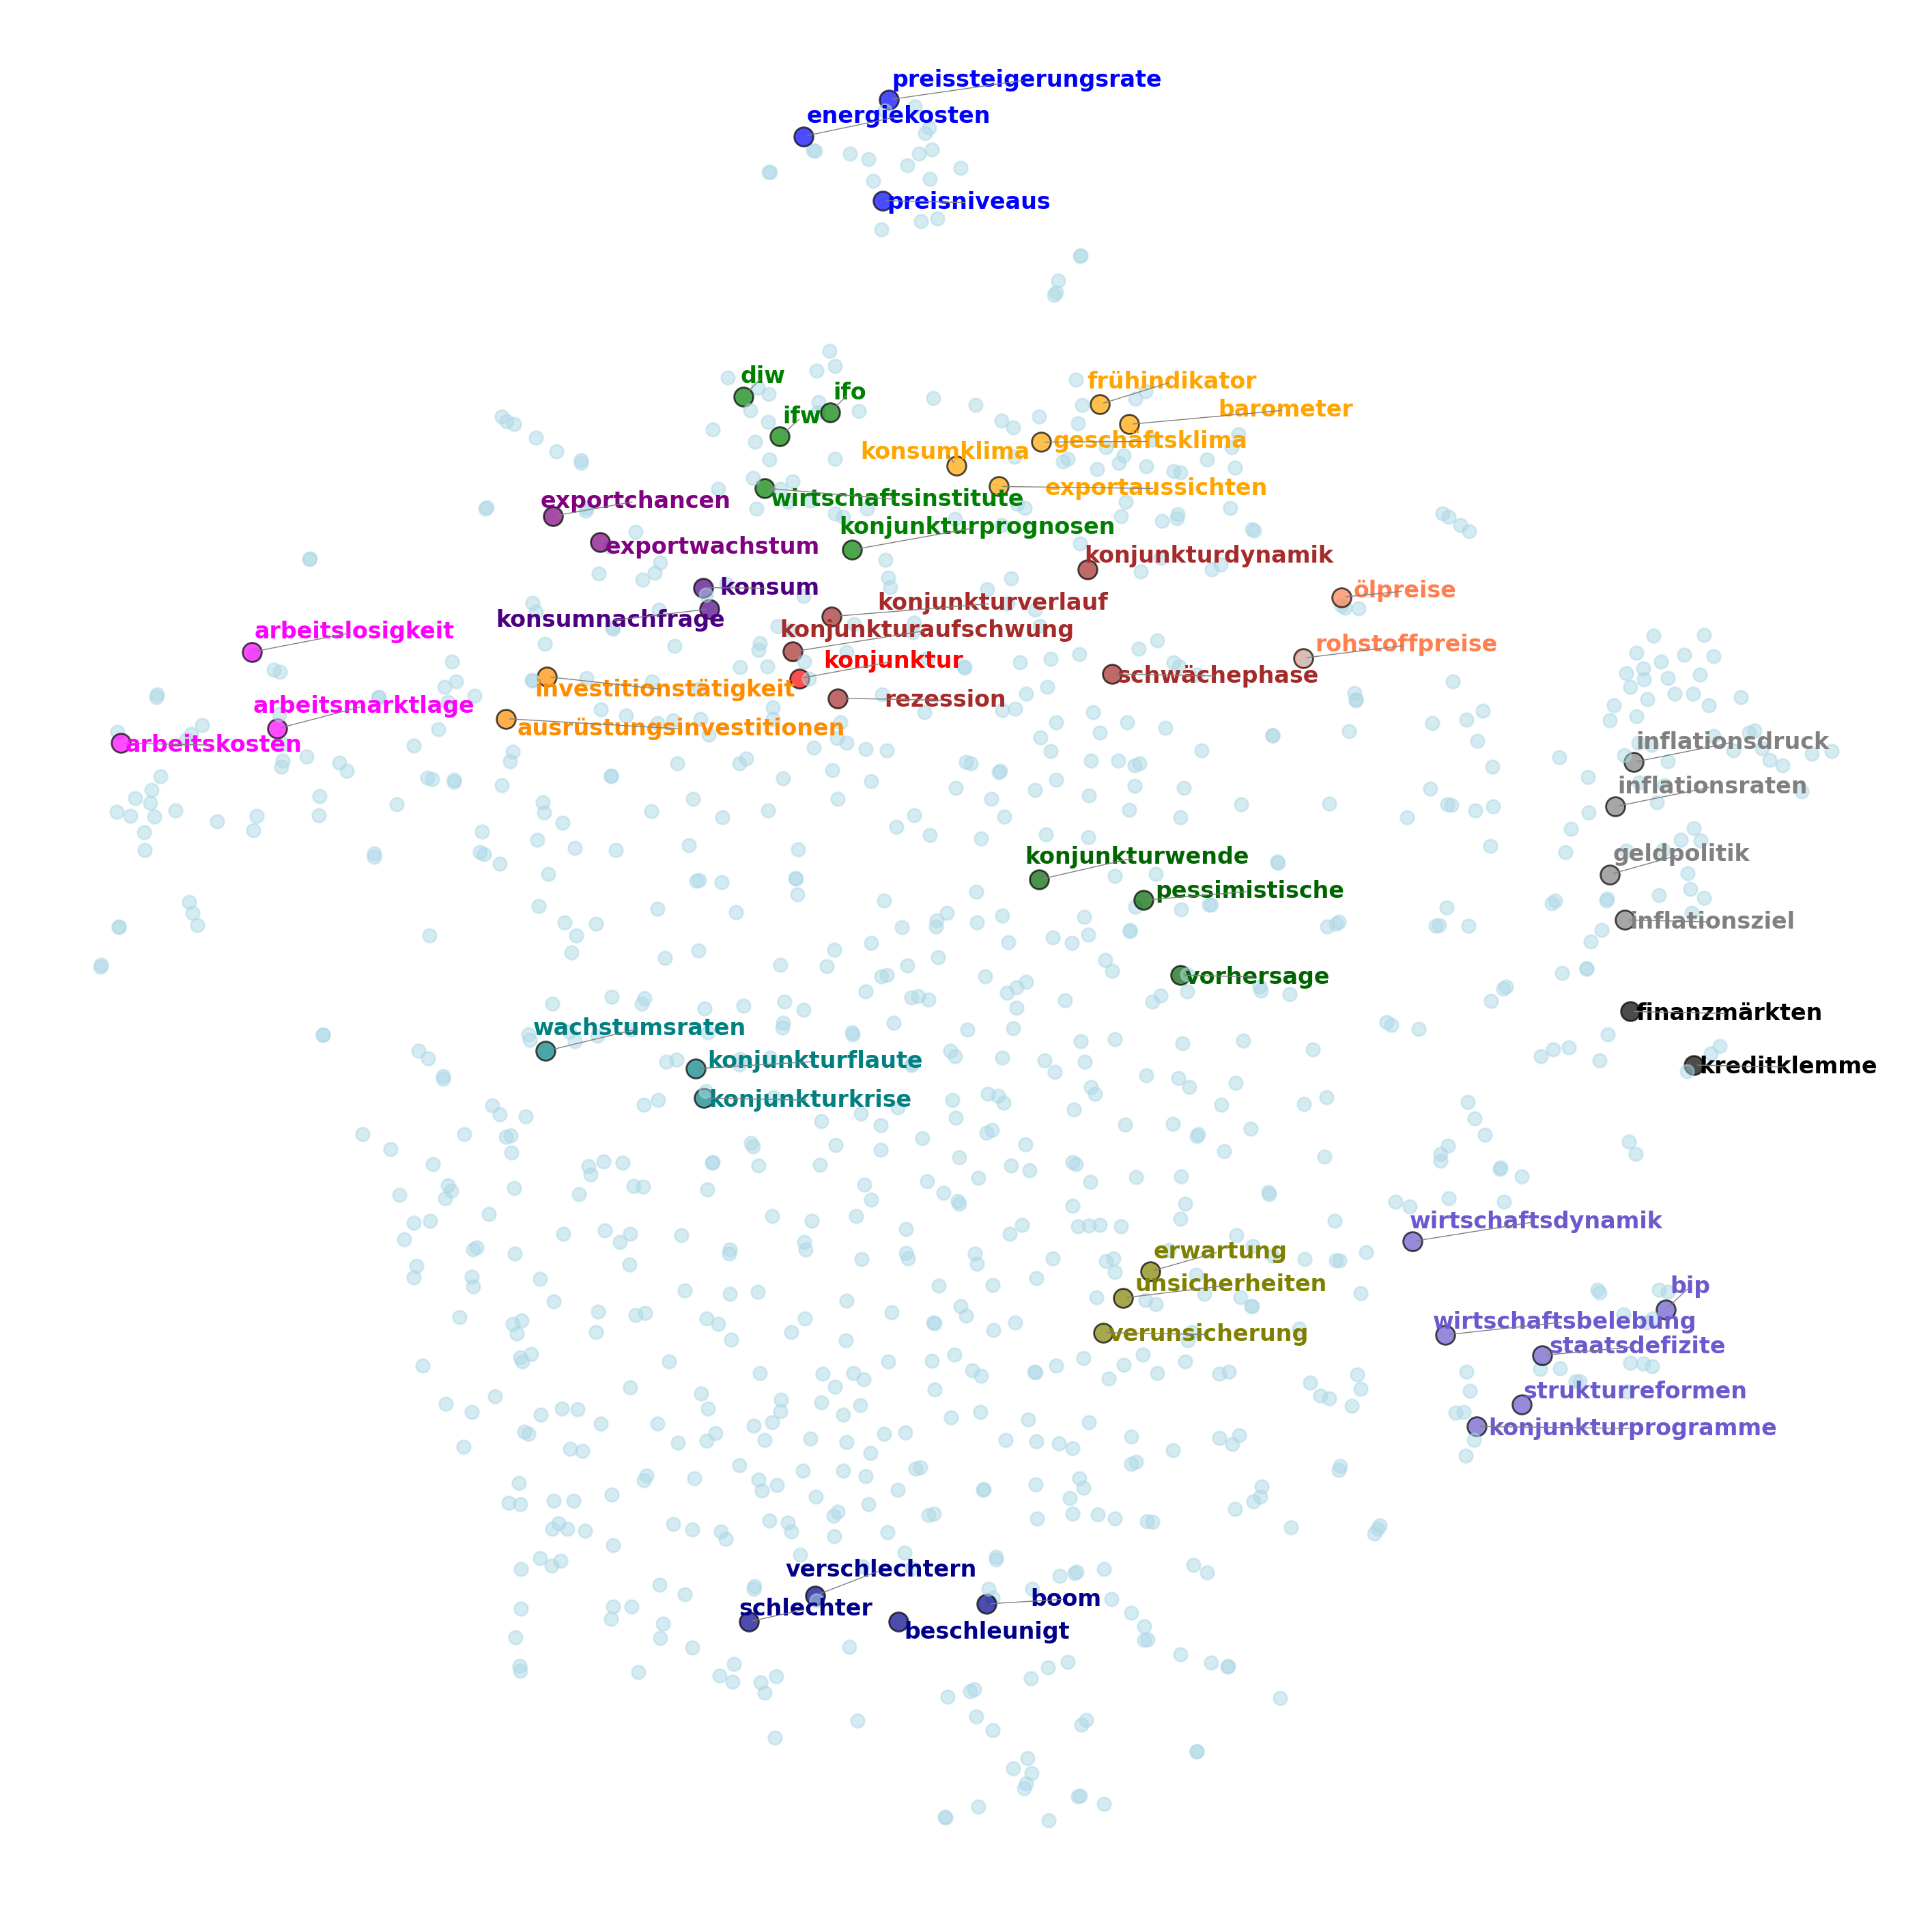

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Convert the closest words to their integer indices
to_draw_int = np.array([vocab_to_int[word] for word in closest_words['konjunktur']]) 
# Extract the corresponding embeddings
to_draw = embeddings_read[to_draw_int]

# Reduce dimensionality using t-SNE for visualization
tsne = TSNE(random_state=300)
# Limit to the closest 1000 words
embed_tsne = tsne.fit_transform(to_draw[:1000, :]) 

# Words to annotate, grouped by color
word_groups = {
    'red': ['konjunktur'],  # Red color specifically for 'konjunktur'
    'blue': ['energiekosten', 'preisniveaus', 'preissteigerungsrate'],  # Price dynamics   
    'green': ['ifo', 'ifw', 'diw', 'wirtschaftsinstitute', 'konjunkturprognosen'],  # Economic research institutes
    'orange': ['geschäftsklima', 'frühindikator', 'barometer', 'exportaussichten', 'konsumklima'],  # Economic sentiment
    'purple': ['exportwachstum', 'exportchancen'],  # Export growth prospects
    'brown': ['konjunkturaufschwung', 'schwächephase', 'rezession', 'konjunkturdynamik', 'konjunkturverlauf'],  # Business cycle phases and conditions
    'indigo': ['konsumnachfrage', 'konsum'], # Consumption
    'darkorange': ['investitionstätigkeit', 'ausrüstungsinvestitionen'],  # Investments
    'magenta': ['arbeitsmarktlage', 'arbeitslosigkeit', 'arbeitskosten'],  # Labor market
    'coral': ['ölpreise', 'rohstoffpreise'], # Commodity price dynamics
    'darkgreen': ['konjunkturwende', 'pessimistische', 'vorhersage'],  # Economic turning points
    'gray': ['inflationsdruck', 'inflationsraten', 'inflationsziel', 'geldpolitik'],  # Inflation
    'black': ['finanzmärkten', 'kreditklemme'],  # Financial markets
    'teal': ['konjunkturflaute', 'konjunkturkrise', 'wachstumsraten'],  # Crises
    'olive': ['erwartung', 'verunsicherung', 'unsicherheiten'],  # Uncertainty/expectations
    'slateblue': ['strukturreformen', 'konjunkturprogramme', 'staatsdefizite', 'bip', 'wirtschaftsdynamik', 'wirtschaftsbelebung'],  # Economic policy
    'darkblue': ['verschlechtern', 'schlechter', 'boom', 'beschleunigt']  # Performance
}
         
# Plotting
fig, ax = plt.subplots(figsize=(18, 18))
texts = []

for idx in range(1000):
    word = int_to_vocab[to_draw_int[idx]]
    # Determine color based on the word group
    color = None
    for group_color, words in word_groups.items():
        if word in words:
            color = group_color
            break
    
    # Plot and annotate
    if color:
        plt.scatter(*embed_tsne[idx, :], color=color, s=100, edgecolor='black', alpha=0.7)
        texts.append(plt.text(embed_tsne[idx, 0], embed_tsne[idx, 1], word, fontsize=12, weight='bold', color=color))
    else:
        plt.scatter(*embed_tsne[idx, :], color='lightblue', s=50, alpha=0.5)

# Adjust the text to avoid overlaps
adjust_text(texts, force_points=0.5, force_text=0.5, expand_points=(2, 2), expand_text=(1.5, 1.5),
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Remove axis for a cleaner look
plt.axis('off')

# Save the plot with high resolution
plt.savefig('tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.savefig('tsne_visualization.eps', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

For publication, we translate all the terms into English.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


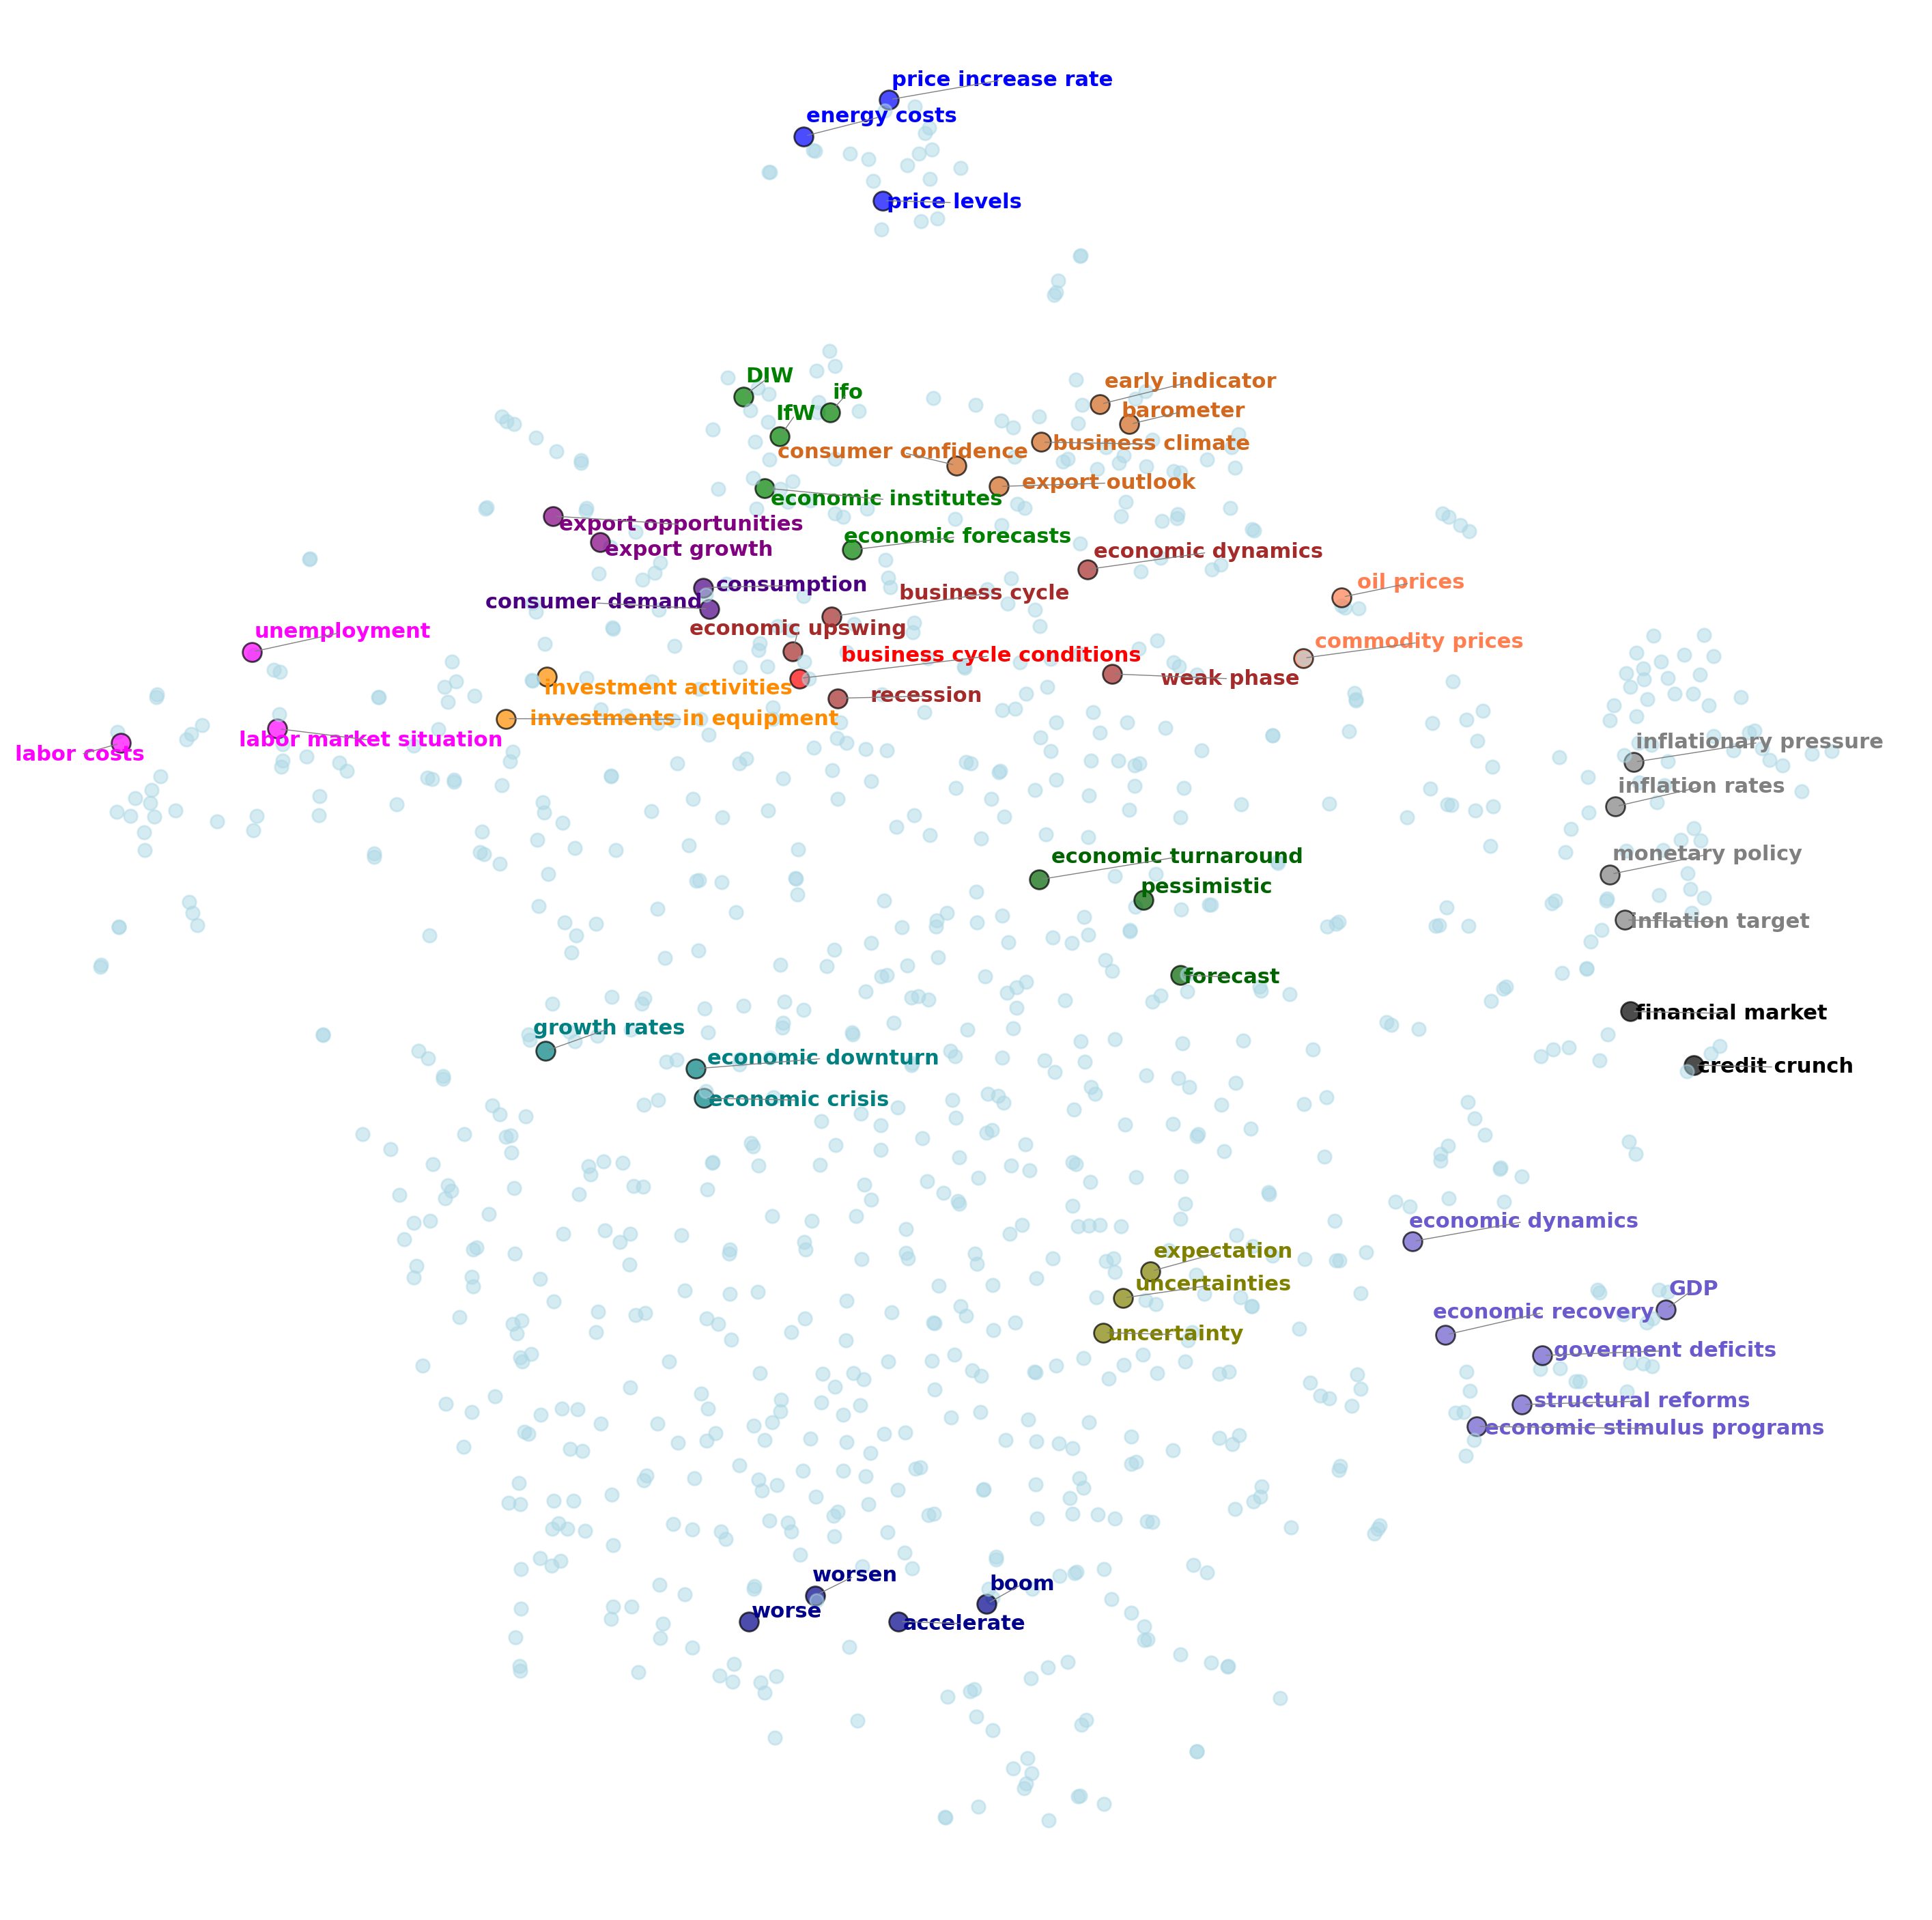

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Convert the closest words to their integer indices
to_draw_int = np.array([vocab_to_int[word] for word in closest_words['konjunktur']]) 
# Extract the corresponding embeddings
to_draw = embeddings_read[to_draw_int]

# Reduce dimensionality using t-SNE for visualization
tsne = TSNE(random_state=300)
# Limit to the closest 1000 words
embed_tsne = tsne.fit_transform(to_draw[:1000, :]) 

# Words to annotate, grouped by color
word_groups = {
    'red': ['konjunktur'],  # Red color specifically for 'konjunktur'
    'blue': ['energiekosten', 'preisniveaus', 'preissteigerungsrate'],  # Price dynamics   
    'green': ['ifo', 'ifw', 'diw', 'wirtschaftsinstitute', 'konjunkturprognosen'],  # Economic research institutes
    'chocolate': ['geschäftsklima', 'frühindikator', 'barometer', 'exportaussichten', 'konsumklima'],  # Economic sentiment
    'purple': ['exportwachstum', 'exportchancen'],  # Export growth prospects
    'brown': ['konjunkturaufschwung', 'schwächephase', 'rezession', 'konjunkturdynamik', 'konjunkturverlauf'],  # Business cycle phases and conditions
    'indigo': ['konsumnachfrage', 'konsum'], # Consumption
    'darkorange': ['investitionstätigkeit', 'ausrüstungsinvestitionen'],  # Investments
    'magenta': ['arbeitsmarktlage', 'arbeitslosigkeit', 'arbeitskosten'],  # Labor market
    'coral': ['ölpreise', 'rohstoffpreise'], # Commodity price dynamics
    'darkgreen': ['konjunkturwende', 'pessimistische', 'vorhersage'],  # Economic turning points
    'gray': ['inflationsdruck', 'inflationsraten', 'inflationsziel', 'geldpolitik'],  # Inflation
    'black': ['finanzmärkten', 'kreditklemme'],  # Financial markets
    'teal': ['konjunkturflaute', 'konjunkturkrise', 'wachstumsraten'],  # Crises
    'olive': ['erwartung', 'verunsicherung', 'unsicherheiten'],  # Uncertainty/expectations
    'slateblue': ['strukturreformen', 'konjunkturprogramme', 'staatsdefizite', 'bip', 'wirtschaftsdynamik', 'wirtschaftsbelebung'],  # Economic policy
    'darkblue': ['verschlechtern', 'schlechter', 'boom', 'beschleunigt']  # Performance
}

# Words to annotate and their translations
translation_mapping = {
    'konjunktur': 'business cycle conditions',
    'energiekosten': 'energy costs',
    'preisniveaus': 'price levels',
    'preissteigerungsrate': 'price increase rate',
    'ifo': 'ifo',
    'ifw': 'IfW',
    'diw': 'DIW',
    'wirtschaftsinstitute': 'economic institutes',
    'konjunkturprognosen': 'economic forecasts',
    'geschäftsklima': 'business climate',
    'frühindikator': 'early indicator',
    'barometer': 'barometer',
    'exportaussichten': 'export outlook',
    'konsumklima': 'consumer confidence',
    'exportwachstum': 'export growth',
    'exportchancen': 'export opportunities',
    'konjunkturaufschwung': 'economic upswing',
    'schwächephase': 'weak phase',
    'rezession': 'recession',
    'konjunkturdynamik': 'economic dynamics',
    'konjunkturverlauf': 'business cycle',
    'konsumnachfrage': 'consumer demand',
    'konsum': 'consumption',
    'investitionstätigkeit': 'investment activities',
    'ausrüstungsinvestitionen': 'investments in equipment',
    'arbeitsmarktlage': 'labor market situation',
    'arbeitslosigkeit': 'unemployment',
    'arbeitskosten': 'labor costs',
    'ölpreise': 'oil prices',
    'rohstoffpreise': 'commodity prices',
    'konjunkturwende': 'economic turnaround',
    'pessimistische': 'pessimistic',
    'vorhersage': 'forecast',
    'inflationsdruck': 'inflationary pressure',
    'inflationsraten': 'inflation rates',
    'inflationsziel': 'inflation target',
    'geldpolitik': 'monetary policy',
    'finanzmärkten': 'financial market',
    'kreditklemme': 'credit crunch',
    'konjunkturflaute': 'economic downturn',
    'konjunkturkrise': 'economic crisis',
    'wachstumsraten': 'growth rates',
    'erwartung': 'expectation',
    'verunsicherung': 'uncertainty',
    'unsicherheiten': 'uncertainties',
    'strukturreformen': 'structural reforms',
    'konjunkturprogramme': 'economic stimulus programs',
    'staatsdefizite': 'goverment deficits',
    'bip': 'GDP',
    'wirtschaftsdynamik': 'economic dynamics',
    'wirtschaftsbelebung': 'economic recovery',
    'verschlechtern': 'worsen',
    'schlechter': 'worse',
    'boom': 'boom',
    'beschleunigt': 'accelerate'    
}
         
# Plotting
fig, ax = plt.subplots(figsize=(18, 18))
texts = []

for idx in range(1000):
    word = int_to_vocab[to_draw_int[idx]]
    # Determine color based on the word group
    color = None
    for group_color, words in word_groups.items():
        if word in words:
            color = group_color
            break
    
    # Plot and annotate
    if color:
        plt.scatter(*embed_tsne[idx, :], color=color, s=100, edgecolor='black', alpha=0.7)
        texts.append(plt.text(embed_tsne[idx, 0], embed_tsne[idx, 1], translation_mapping[word], fontsize=11, weight='bold', color=color))
    else:
        plt.scatter(*embed_tsne[idx, :], color='lightblue', s=50, alpha=0.5)
        
# Adjust the text to avoid overlaps
adjust_text(texts, force_points=0.5, force_text=0.5, expand_points=(2, 2), expand_text=(1.5, 1.5),
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Remove axis for a cleaner look
plt.axis('off')

# Save the plot with high resolution
plt.savefig('tsne_visualization_eng.png', dpi=300, bbox_inches='tight')
plt.savefig('tsne_visualization_eng.eps', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()